# **Introduction to Social Data Science**
**Group 30: \*insert names, student numbers, and emails here here\*

## Importing Packages

In [126]:
#Importing packages
import requests
import bs4 as bs
import pandas as pd
import re
import datetime
from datetime import datetime

In [127]:
#Things to import
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time, tqdm, json, re, requests, os, csv
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import snscrape.modules.twitter as sntwitter
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Getting data from Wikipedia

In [248]:
# Getting the URL
url = 'https://en.wikipedia.org/wiki/List_of_post%E2%80%932016_election_Donald_Trump_rallies'
response = requests.get(url, headers={'names': 'Laurits Harbom Marcussen, August Maigaard Rubin, Matthew Stephen Boddie', 'emails': 'zhg932@alumni.ku.dk, xkb163@alumni.ku.dk xgf551@alumni.ku.dk'})
soup = bs.BeautifulSoup(response.content, 'lxml') # Get the HTML of the website
tables = soup.find_all('table')

In [249]:
#Converts html's to dataframes, convert lists to dataframe
df=pd.read_html(str(tables))
df1=pd.DataFrame(df[8])
df2=pd.DataFrame(df[9])

#Isolate the "Date of rally2 columns, and combine the 2 tables
dates = pd.concat([df1["Date of rally"], df2["Date of rally"]])
dates = dates.reset_index(drop=True)

#Cleans wiki-data
def clean():
    for i in range(len(dates)):
        dates[i] = re.sub(r'\[\d+\]', '', dates[i])
        date_list = dates[i].split(',') # # Removing the weekday and the comma from the strings by splitting the strings and merging them again
        dates[i] = ''.join(date_list[1:])
        dates[i] = pd.to_datetime(dates[i]).strftime('%Y-%m-%d') # Converting to datetime format
    return dates
clean()

0     2020-06-20
1     2020-06-23
2     2020-08-17
3     2020-08-17
4     2020-08-18
         ...    
65    2020-11-02
66    2020-11-02
67    2020-12-05
68    2021-01-04
69    2021-01-06
Name: Date of rally, Length: 70, dtype: object

In [250]:
#Craeting a list of all the dates we wanna analyze
all_dates = pd.date_range(start='5/21/2020', end='2/05/2021')
date_list = all_dates.strftime('%Y-%m-%d')
s = pd.Series(date_list)

In [251]:
#Comparing the list of all dates and the list of rally dates, and making a binary list of coinciding dates
binary_list = []
for i in s:
    if i in dates.values: 
        binary_list.append(1)
    else: 
        binary_list.append(0)
binaries = pd.Series(binary_list)

In [252]:
#Making a combined list
rallies = [[s[i], binaries[i]] for i in range(len(binary_list))]

In [253]:
#Get a dictionary with the frequency of rallies each day
date_frq = {}
#fill the dictionary
for date in dates:
    cnt = 0
    for d in dates:
        if date == d:
            cnt += 1
        date_frq[date] = cnt

In [254]:
for i in range(len(rallies)):
    if rallies[i][0] in date_frq.keys():
        rallies[i].append(date_frq[rallies[i][0]])
    else:
        rallies[i].append(0)

In [256]:
#Making a dataframe with the dates
df_rally = pd.DataFrame(rallies, columns=['date', 'rally', 'amount'])

In [257]:
#create a date column with datetime
df_rally['date'] = pd.to_datetime(df_rally['date'])

In [258]:
df_rally

,date,rally,amount
0,2020-05-21,0,0
1,2020-05-22,0,0
2,2020-05-23,0,0
3,2020-05-24,0,0
4,2020-05-25,0,0
...,...,...,...
256,2021-02-01,0,0
257,2021-02-02,0,0
258,2021-02-03,0,0
259,2021-02-04,0,0


In [260]:
#Get the rallies within three days of the given index
within_3_days = []
cnt = 0
for i in range(len(rallies)):
    for d_r in rallies[(i-3):(i+3)]:
        cnt += d_r[2]
    within_3_days.append(cnt)
    cnt = 0
df_rally['within_7_days'] = within_3_days

In [278]:
df_rally.iloc[150:160]

,date,rally,amount,within_7_days
150,2020-10-18,1,1,9
151,2020-10-19,1,2,9
152,2020-10-20,1,1,7
153,2020-10-21,1,1,7
154,2020-10-22,0,0,9
155,2020-10-23,1,2,8
156,2020-10-24,1,3,10
157,2020-10-25,1,1,12
158,2020-10-26,1,3,14
159,2020-10-27,1,3,13


## Get Twitter data

In [ ]:
#Log function to log progress during scraping
def log(tweet, logfile,output_path=os.getcwd()):
    """Logging function to create a log of the scraping status"""
    #Open or create the csv log file
    if os.path.isfile(logfile):
        log = open(logfile,'a')
    else:
        log = open(logfile, 'w')
        header = ['timestamp', 'status_code', 'length', 'output_file']
        log.write(';'.join(header) + '\n')
    
    #Get log information
    #If the tweet did not fail, the status code is 200
    status_code = 200
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    #Should be 27 values along with the tweet
    length = len(tweet)
    
    #append to log file
    with open(logfile, 'a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path}' + "\n")
        

In [ ]:
#Defining the query and the list for scraping
#21/05/2020 -> 05/02/2021
query = "(#stopthesteal) lang:en until:2021-02-06 since:2020-05-21"
tweets = []

In [ ]:
#Scraping the tweets with snscrape
#Getting the tweets:
logfile = 'tweet_scrape_log.csv'
for tweet in tqdm.tqdm(sntwitter.TwitterSearchScraper(query).get_items()):
    try:
        tweets.append([tweet.date, tweet.content])
    except Exception as e:
        print('Something went wrong')
        print(e)
        print(f'Last tweet: {tweet.date} {tweet.content}')
        with open('tweets_backup.csv', 'w', encoding='utf8') as f:
            write = csv.writer(f)
            write.writerow(['datetime', 'text'])
            write.writerows(tweets)
        continue
    log(vars(tweet), logfile)

In [ ]:
#If everything went to plan, save the list as a csv
with open('tweets.csv', 'w', encoding='utf8') as f:
    write = csv.writer(f)
    write.writerow(['datetime', 'text'])
    write.writerows(tweets)

In [ ]:
#Get dataframe from csv
df_tweets = pd.read_csv('tweets.csv')
df_tweets['datetime'] = pd.to_datetime(df_tweets['datetime'])

## Clean twitter data and do sentiment analysis

In [ ]:
#Get copy of dataframe to maintain primary dataframe
dirty_text = df_tweets['text'].copy()

In [ ]:
#Define function for cleaning tweets
def clean(array_of_tweets):
    """This function will take a list of tweets and clean them in the following manner:
    Make lowercase, Replace mentions with @user, and remove any links"""
    for i in range(len(array_of_tweets)):
        #make lower() and strip
        new_text = array_of_tweets[i].lower().strip()
        #replace @user 
        new_text = re.sub(r'\@\w+', '', new_text)
        #remove links
        new_text = re.sub(r'https?://\w+\.\w+/?\w+', '', new_text)
        #remove (video)
        new_text = re.sub(r'\(video\)', '', new_text)
        #remove \r and \n
        new_text = re.sub(r'\r', '', new_text)
        new_text = re.sub(r'\n', '', new_text)
        #remove hashtags
        new_text = re.sub(r'#\w+', '', new_text)
        #remove punctuation 
        new_text = re.sub(r'\.', '', new_text)
        array_of_tweets[i] = new_text
    return array_of_tweets

In [ ]:
#Get clean_text
clean_text = clean(dirty_text)

In [ ]:
#Making a column with the cleaned text
df_tweets['cleaned text'] = clean_text

In [ ]:
#Using Vader to find perform sentiment analysis
analyzer = SentimentIntensityAnalyzer()
sentiment = []
for i in tqdm.tqdm(df_tweets['cleaned text'].values):
    score = analyzer.polarity_scores(i)['compound']
    sentiment.append(score)

In [ ]:
#Add calculated scores to dataframe
df_tweets['sentiment_score'] = sentiment

In [ ]:
#Save a dataframe with just the cleaned tweets and the sentiment score to use for bag of words later
df_tweets_for_bag = df_tweets.copy()
df_tweets_for_bag.drop(['text', 'datetime'], axis=1, inplace=True)
df_tweets_for_bag.to_csv('tweets_for_bag.csv', encoding='utf8')

In [ ]:
#Get descriptive statistics
df_tweets.describe()

## Split - Apply - Transform to get average sentiment

In [ ]:
#Create date column to split dataframe with
df_tweets['date'] = df_tweets['datetime'].dt.date

In [ ]:
#Splitting the dataframe by date, getting the sum and count of the sentiment to calculate average
tweets_by_date = df_tweets.groupby('date')['sentiment_score'].agg(['sum', 'count'])

In [ ]:
#Creating an average column 
tweets_by_date['avg'] = tweets_by_date['sum'] / tweets_by_date['count']

And I know what you're thinking. "Why don't you just use the mean function to get the average?". Well you see, that's because... \*insert good answer here\*

In [ ]:
#Drop sum and rename count
tweets_by_date.drop('sum', axis=1, inplace=True)
tweets_by_date.columns = ['tweet_count', 'total_avg']

In [ ]:
#Getting all the positive values
positive_sentiment = df_tweets[df_tweets['sentiment_score'] > 0].groupby('date')['sentiment_score'].agg(['sum', 'count'])
#Getting the positive average
positive_sentiment['positive_avg'] = positive_sentiment['sum'] / positive_sentiment['count']
print(positive_sentiment)

#Getting all the negative values
negative_sentiment = df_tweets[df_tweets['sentiment_score'] < 0].groupby('date')['sentiment_score'].agg(['sum', 'count']) 
#Getting negative average
negative_sentiment['negative_avg'] = negative_sentiment['sum'] / negative_sentiment['count']
print(negative_sentiment)

In [ ]:
#Dropping sum
positive_sentiment.drop('sum', axis=1, inplace=True)
negative_sentiment.drop('sum', axis=1, inplace=True)
# Renaming the columns
positive_sentiment.columns = ['positive_count', 'positive_avg']
negative_sentiment.columns = ['negative_count', 'negative_avg']

In [ ]:
#Adding the positive and the negative to combined_tweets
all_sentiment = positive_sentiment.join(negative_sentiment, how='outer')
df_combined_tweets = tweets_by_date.join(all_sentiment, how='outer')
#Add day column for plots
df_combined_tweets['day'] = df_combined_tweets.index

In [ ]:
#Save combined dataframe to csv for future use
#df_combined_tweets.to_csv('combined_tweets.csv', encoding='utf8')
df_combined_tweets = pd.read_csv('combined_tweets.csv', encoding='utf8')

In [ ]:
#Get descriptive statistics
df_combined_tweets.describe()

## Import twitter data and combine

In [128]:
#Load tweet dataframe from csv
df_combined_tweets = pd.read_csv('combined_tweets.csv')
df_combined_tweets.head()
#Convert date to datetime
df_combined_tweets['date'] = pd.to_datetime(df_combined_tweets['date'])
#Merge the two dataframes
merged_df = pd.merge(df_combined_tweets, df_rally, on='date', how='left')
merged_df.iloc[-120:-70]

NameError: name 'df_rally' is not defined

In [55]:
#Saving the merged dataframe as a csv
#merged_df.to_csv('tweet_data.csv', encoding='utf8')

In [129]:
merged_df = pd.read_csv('tweet_data.csv', encoding='utf8')

In [130]:
#Drop unused columns from dataframe
merged_df.drop(['Unnamed: 0', 'days_since_last_rally', 'days_to_next_rally'], axis=1, inplace=True)

In [161]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

## Descriptive plots

#### Descriptive Plots

In [169]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

<AxesSubplot:title={'center':'Average sentiment over time'}, xlabel='Date', ylabel='Sentiment'>

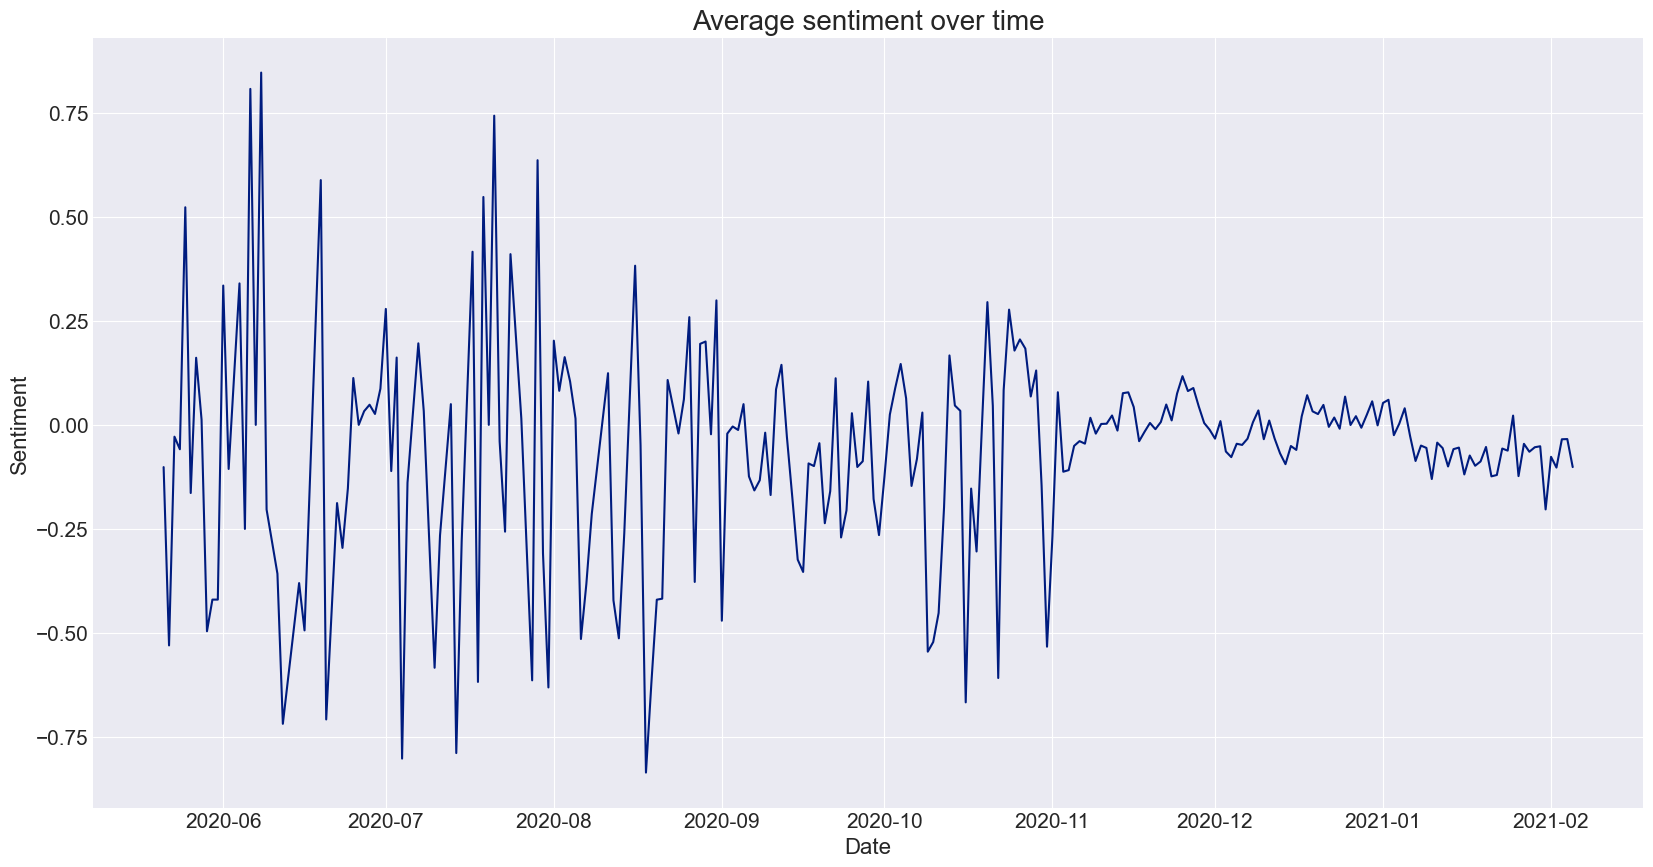

In [266]:
#Sentiment over time
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(20,10))

ax.set_title('Average sentiment over time') 
ax.title.set_fontsize(20) 
ax.set_xlabel('Date')
ax.xaxis.label.set_fontsize(16)
ax.set_ylabel('Sentiment')
ax.yaxis.label.set_fontsize(16)
plt.savefig('plot1_average_sentiment_over_time')

sns.lineplot(x=merged_df['date'], y=merged_df['total_avg'])

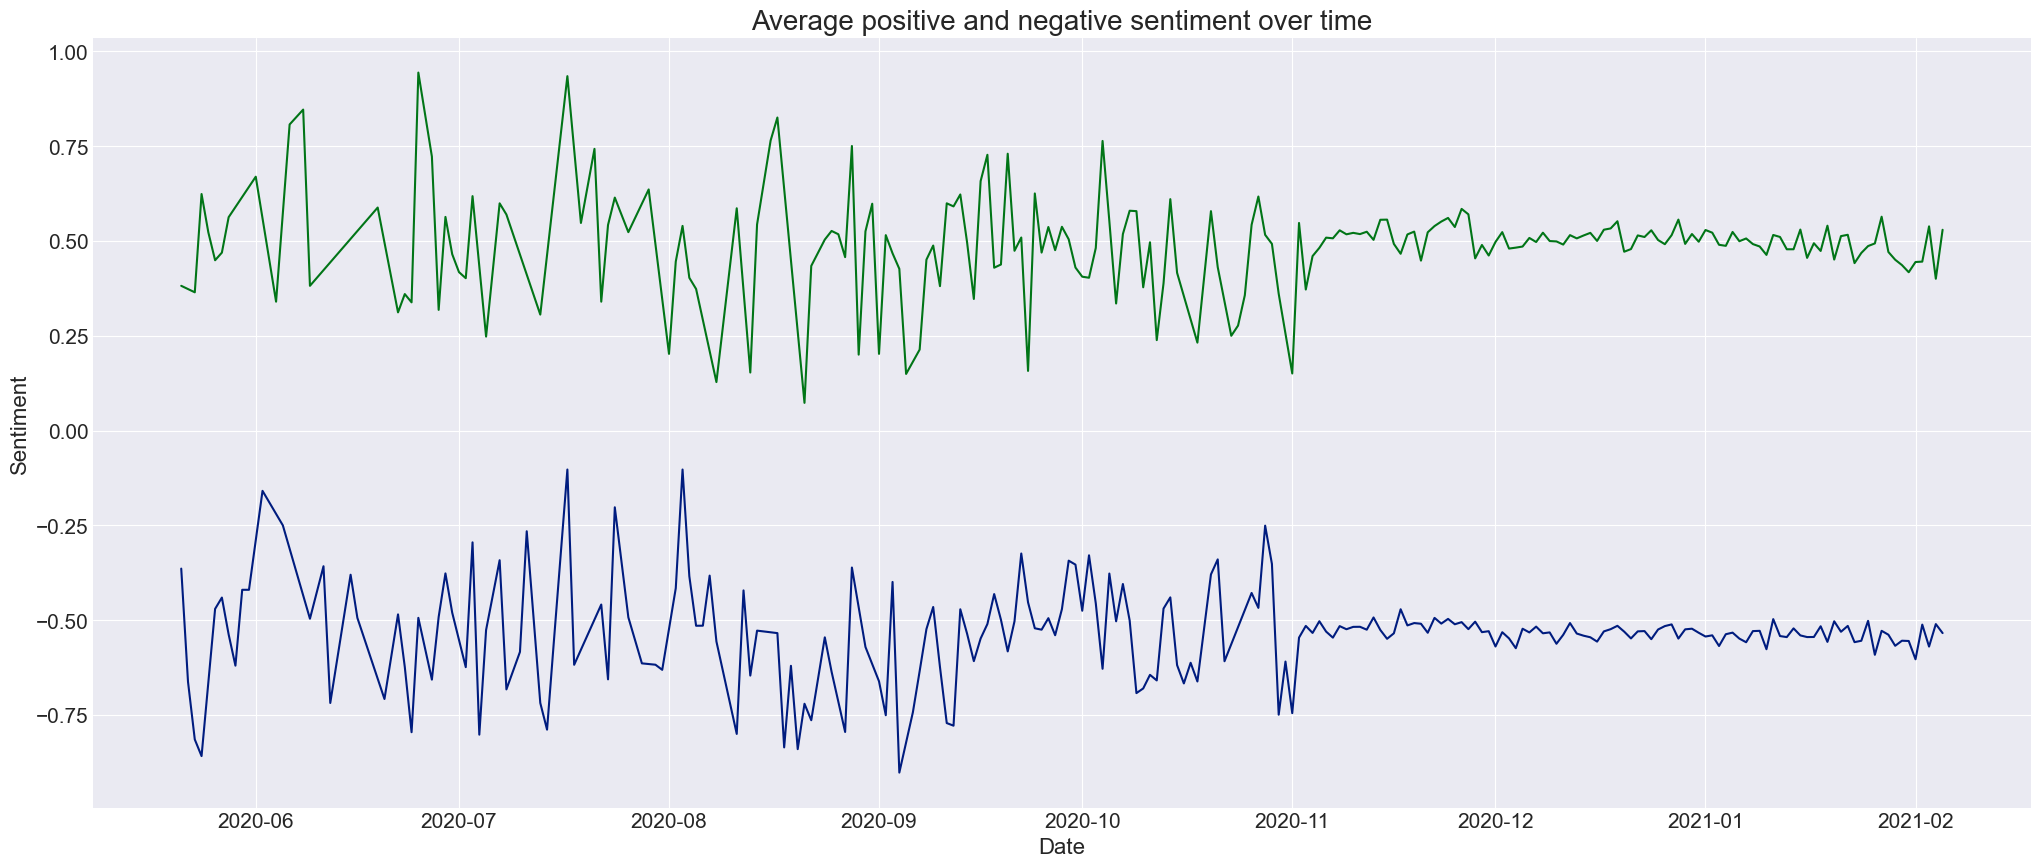

In [267]:
#Avg positive and negative sentiment over time
fig, ax = plt.subplots(figsize=(25,10))
sns.lineplot(x=merged_df['date'], y=merged_df['negative_avg'])
sns.lineplot(x=merged_df['date'], y=merged_df['positive_avg'])

ax.set_title('Average positive and negative sentiment over time') 
ax.title.set_fontsize(20) 
ax.set_xlabel('Date')
ax.xaxis.label.set_fontsize(16)
ax.set_ylabel('Sentiment')
ax.yaxis.label.set_fontsize(16)
plt.savefig('plot2_positive_and_negative_over_time')

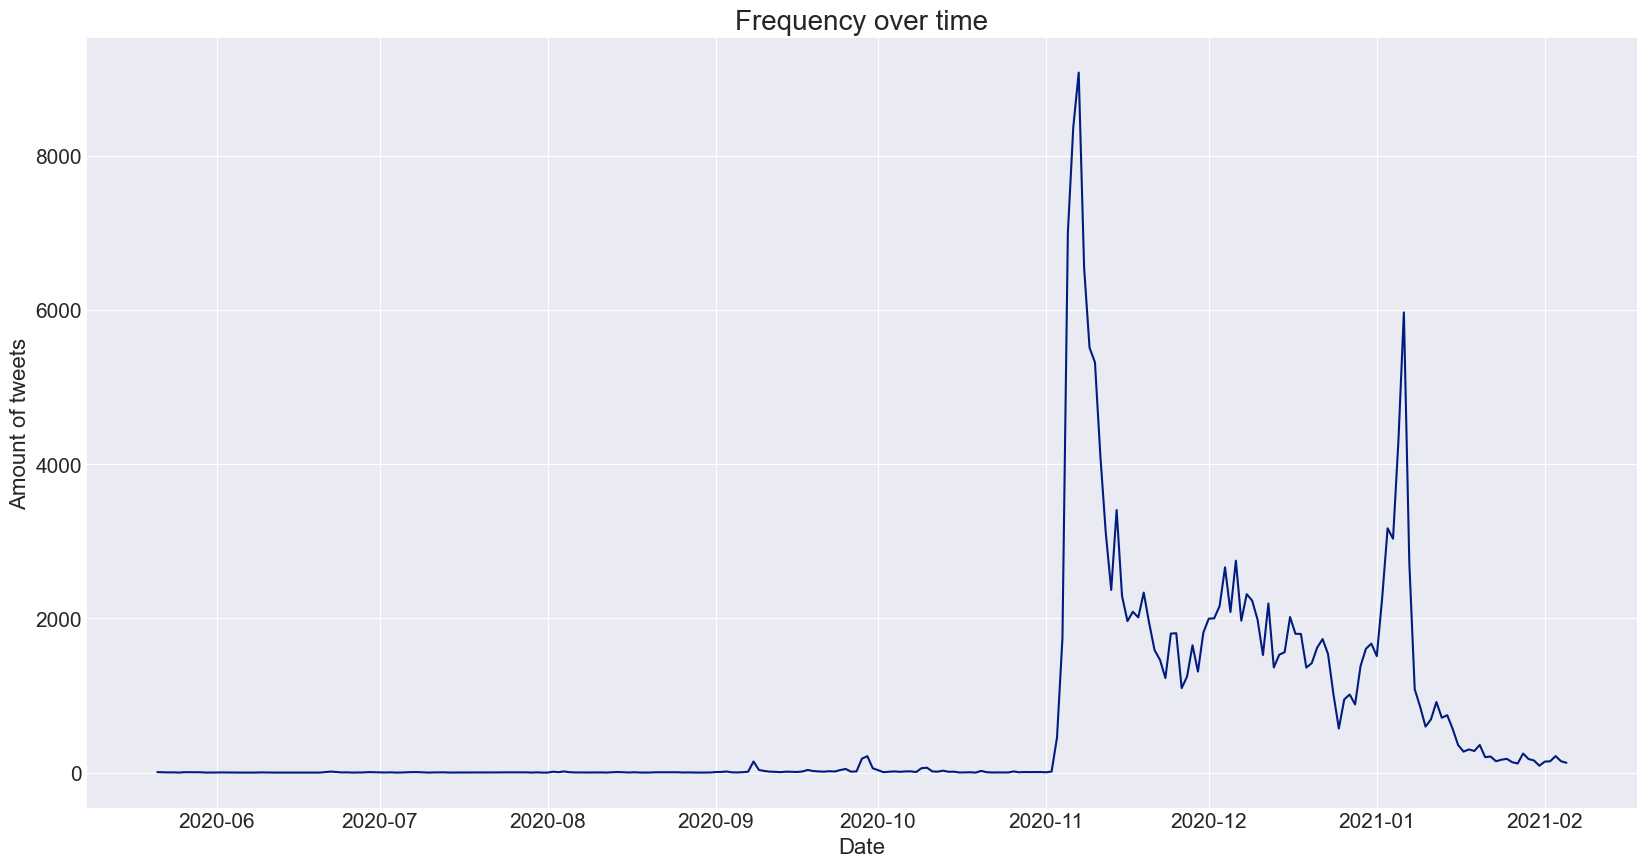

In [268]:
#Frequency over time
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x=merged_df['date'], y=merged_df['tweet_count'])
ax.set_title('Frequency over time') 
ax.title.set_fontsize(20) 
ax.set_xlabel('Date')
ax.xaxis.label.set_fontsize(16)
ax.set_ylabel('Amount of tweets')
ax.yaxis.label.set_fontsize(16)
plt.savefig('plot3_frequency_over_time')

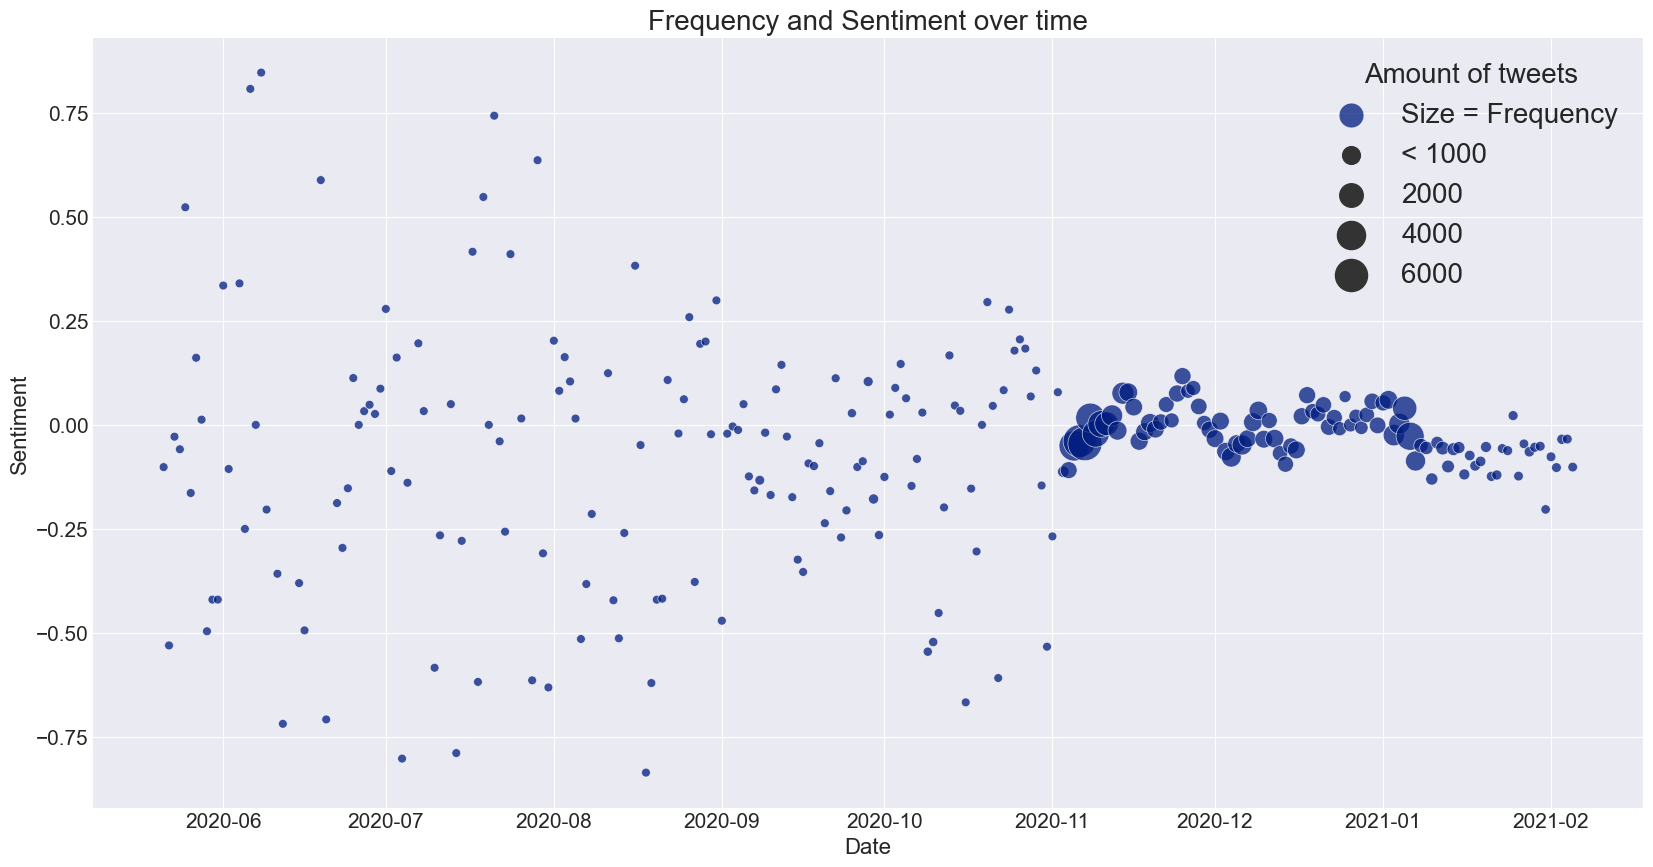

In [269]:
#Frequency & Sentiment
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=merged_df['date'], y=merged_df['total_avg'], size=merged_df['tweet_count'], sizes=(40, 600), alpha=0.75)
ax.set_title('Frequency and Sentiment over time') 
ax.title.set_fontsize(20) 
ax.set_xlabel('Date')
ax.xaxis.label.set_fontsize(16)
ax.set_ylabel('Sentiment')
ax.yaxis.label.set_fontsize(16)
plt.legend(['Size = Frequency', '< 1000', '2000', '4000', '6000', '8000'], title='Amount of tweets', fontsize='20', title_fontsize='20')
plt.savefig('plot4_frequency_and_sentiment')

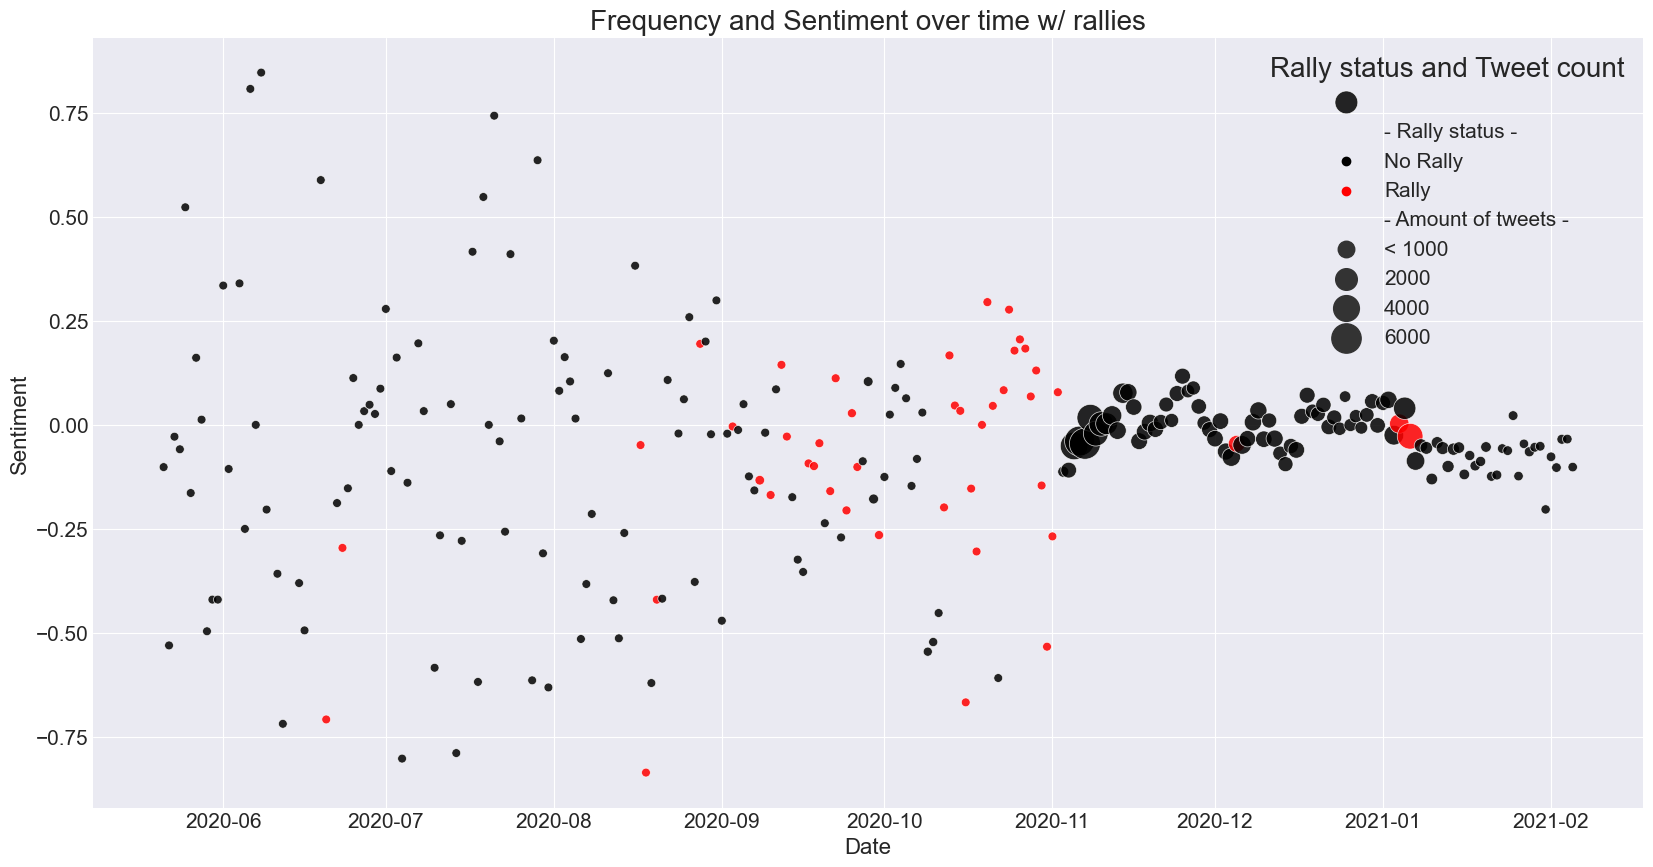

In [270]:
#Frequency & Sentiment, with the rallies
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=merged_df['date'], y=merged_df['total_avg'], hue=merged_df['rally'], palette=['black', 'red'], size=merged_df['tweet_count'], sizes=(40, 500), alpha=0.85)
ax.set_title('Frequency and Sentiment over time w/ rallies') 
ax.title.set_fontsize(20) 
ax.set_xlabel('Date')
ax.xaxis.label.set_fontsize(16)
ax.set_ylabel('Sentiment')
ax.yaxis.label.set_fontsize(16)
plt.legend(['', '- Rally status -', 'No Rally', 'Rally', '- Amount of tweets -', '< 1000', '2000', '4000', '6000', '8000'], title='Rally status and Tweet count', fontsize='15', title_fontsize='20')
plt.savefig('plot5_frequency_sentiment_with_rallies')

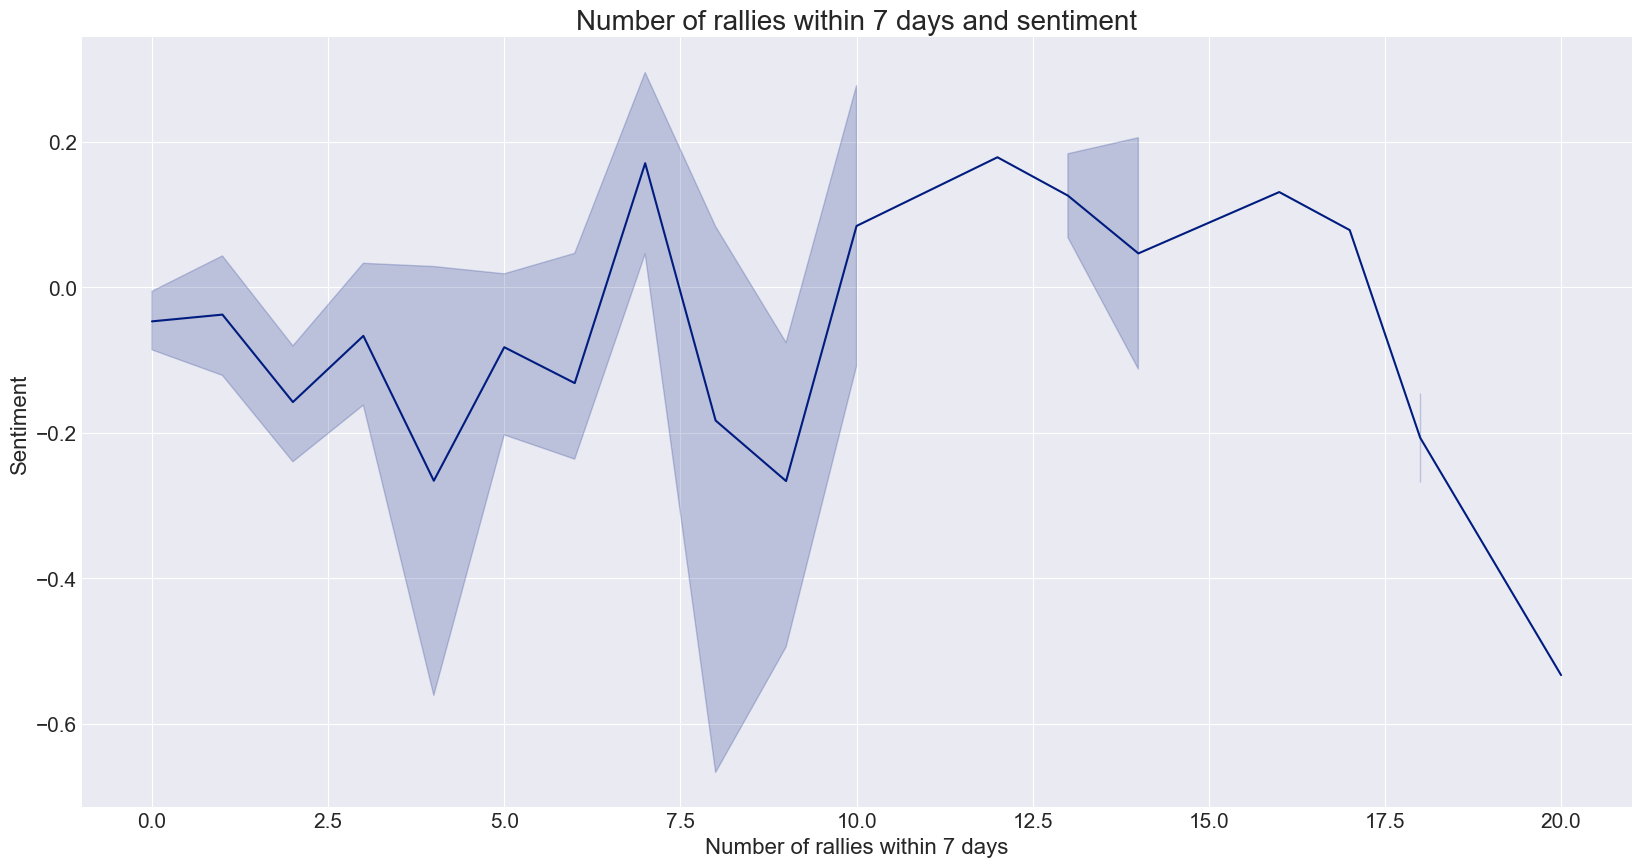

In [271]:
#Total Average by amount of rallies within 7 days
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x=merged_df['within_7_days'], y=merged_df['total_avg'])
ax.set_title('Number of rallies within 7 days and sentiment') 
ax.title.set_fontsize(20) 
ax.set_xlabel('Number of rallies within 7 days')
ax.xaxis.label.set_fontsize(16)
ax.set_ylabel('Sentiment')
ax.yaxis.label.set_fontsize(16)
plt.savefig('plot6_rallies_within_7_and_sentiment')

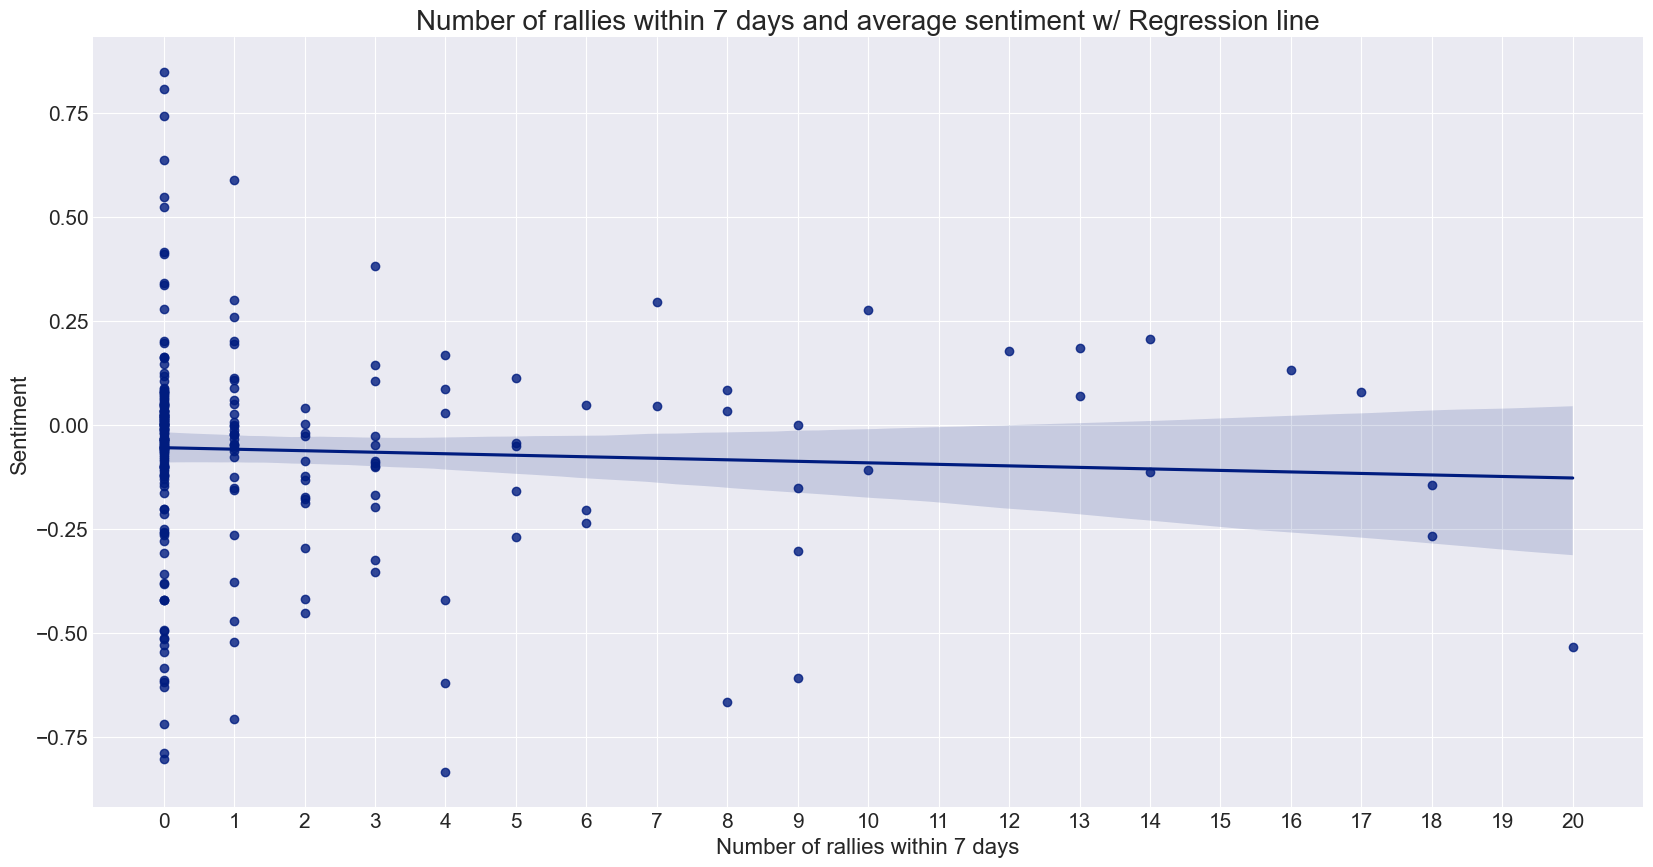

In [272]:
#Total Average by amount of rallies within 7 days
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xticks(range(0,21,1))
sns.regplot(x='within_7_days', y='total_avg', data=merged_df)
ax.set_title('Number of rallies within 7 days and average sentiment w/ Regression line') 
ax.title.set_fontsize(20) 
ax.set_xlabel('Number of rallies within 7 days')
ax.xaxis.label.set_fontsize(16)
ax.set_ylabel('Sentiment')
ax.yaxis.label.set_fontsize(16)
plt.savefig('plot7_within_7_sentiment_regression')

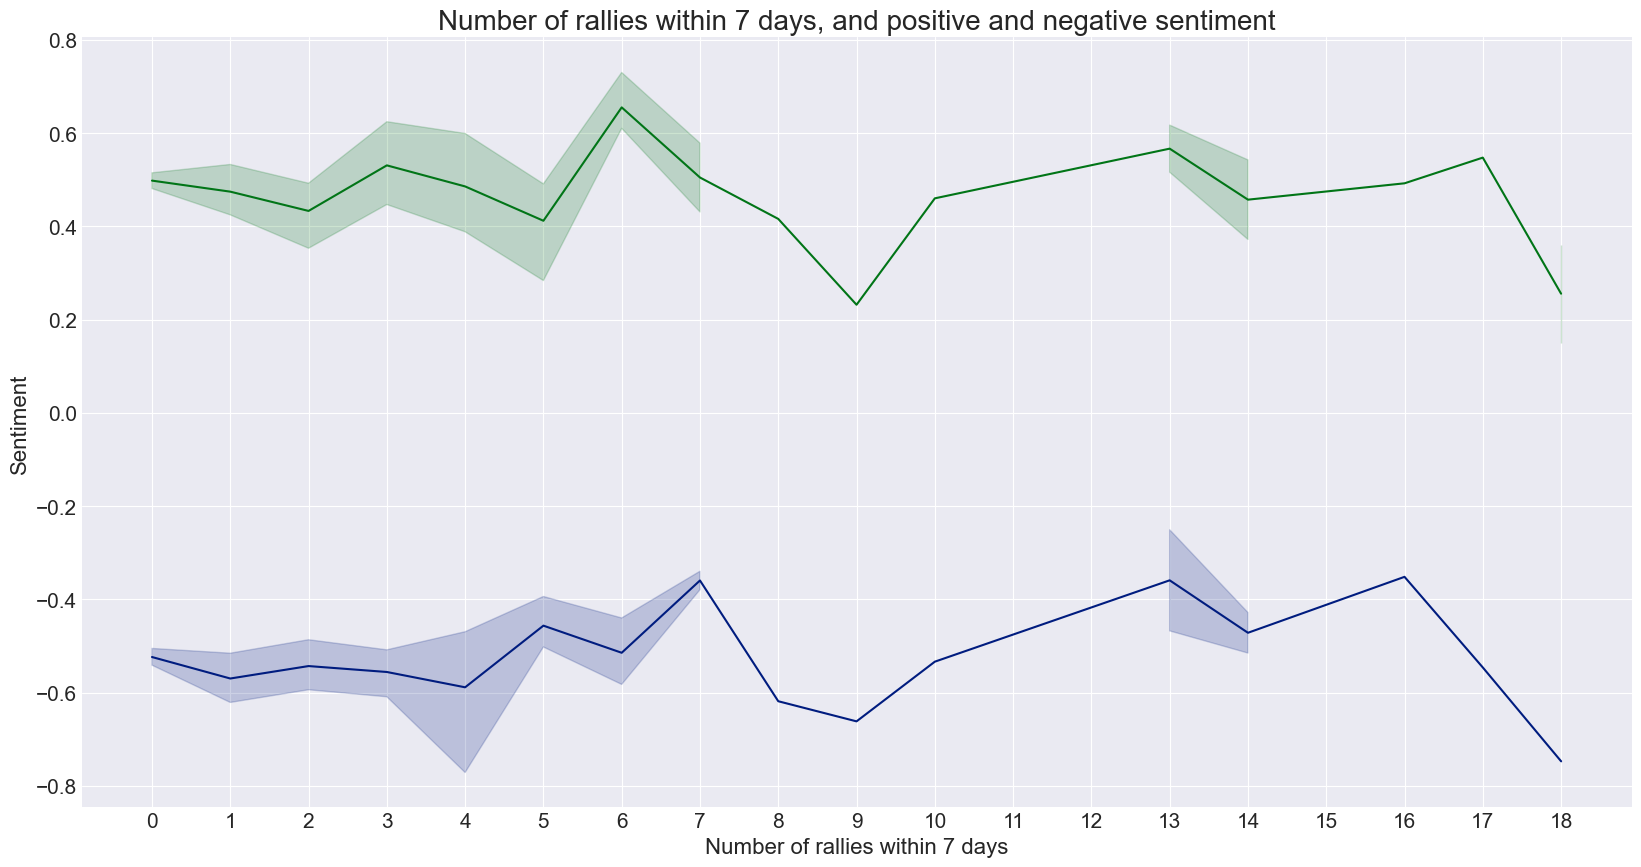

In [273]:
#Negative by amount of rallies within 7 days
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xticks(range(0,21,1))
sns.lineplot(x=pos_neg_df['within_7_days'], y=pos_neg_df['negative_avg'])
sns.lineplot(x=pos_neg_df['within_7_days'], y=pos_neg_df['positive_avg'])
ax.set_title('Number of rallies within 7 days, and positive and negative sentiment') 
ax.title.set_fontsize(20) 
ax.set_xlabel('Number of rallies within 7 days')
ax.xaxis.label.set_fontsize(16)
ax.set_ylabel('Sentiment')
ax.yaxis.label.set_fontsize(16)
plt.savefig('plot8_within_7_positive_negative')

## Regression

In [143]:
#Creating a sepearte df for regression, just in case
regression_df = merged_df.copy()
regression_df

,date,tweet_count,total_avg,positive_count,positive_avg,negative_count,negative_avg,day,rally,amount,within_7_days
0,2020-05-21,7,-0.101471,1.0,0.381800,3.0,-0.364033,2020-05-21,0,0,0
1,2020-05-22,5,-0.530020,NaN,NaN,4.0,-0.662525,2020-05-22,0,0,0
2,2020-05-23,3,-0.028400,2.0,0.364700,1.0,-0.814600,2020-05-23,0,0,0
3,2020-05-24,4,-0.058650,1.0,0.623900,1.0,-0.858500,2020-05-24,0,0,0
4,2020-05-25,1,0.522900,1.0,0.522900,NaN,NaN,2020-05-25,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
239,2021-02-01,143,-0.076739,54.0,0.444609,58.0,-0.603148,2021-02-01,0,0,0
240,2021-02-02,148,-0.102641,44.0,0.445641,68.0,-0.511751,2021-02-02,0,0,0
241,2021-02-03,215,-0.034601,56.0,0.538586,66.0,-0.569697,2021-02-03,0,0,0
242,2021-02-04,148,-0.034109,32.0,0.400462,35.0,-0.510371,2021-02-04,0,0,0


### Simple linear regression - Total_avg

In [144]:
#Get our x and y's
x = np.array(regression_df['within_7_days']).reshape((-1, 1))
y1 = np.array(regression_df['total_avg'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.02200
Date:                Mon, 22 Aug 2022   Prob (F-statistic):              0.882
Time:                        11:20:43   Log-Likelihood:                 146.45
No. Observations:                 190   AIC:                            -288.9
Df Residuals:                     188   BIC:                            -282.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5318      0.009    -59.003      0.0

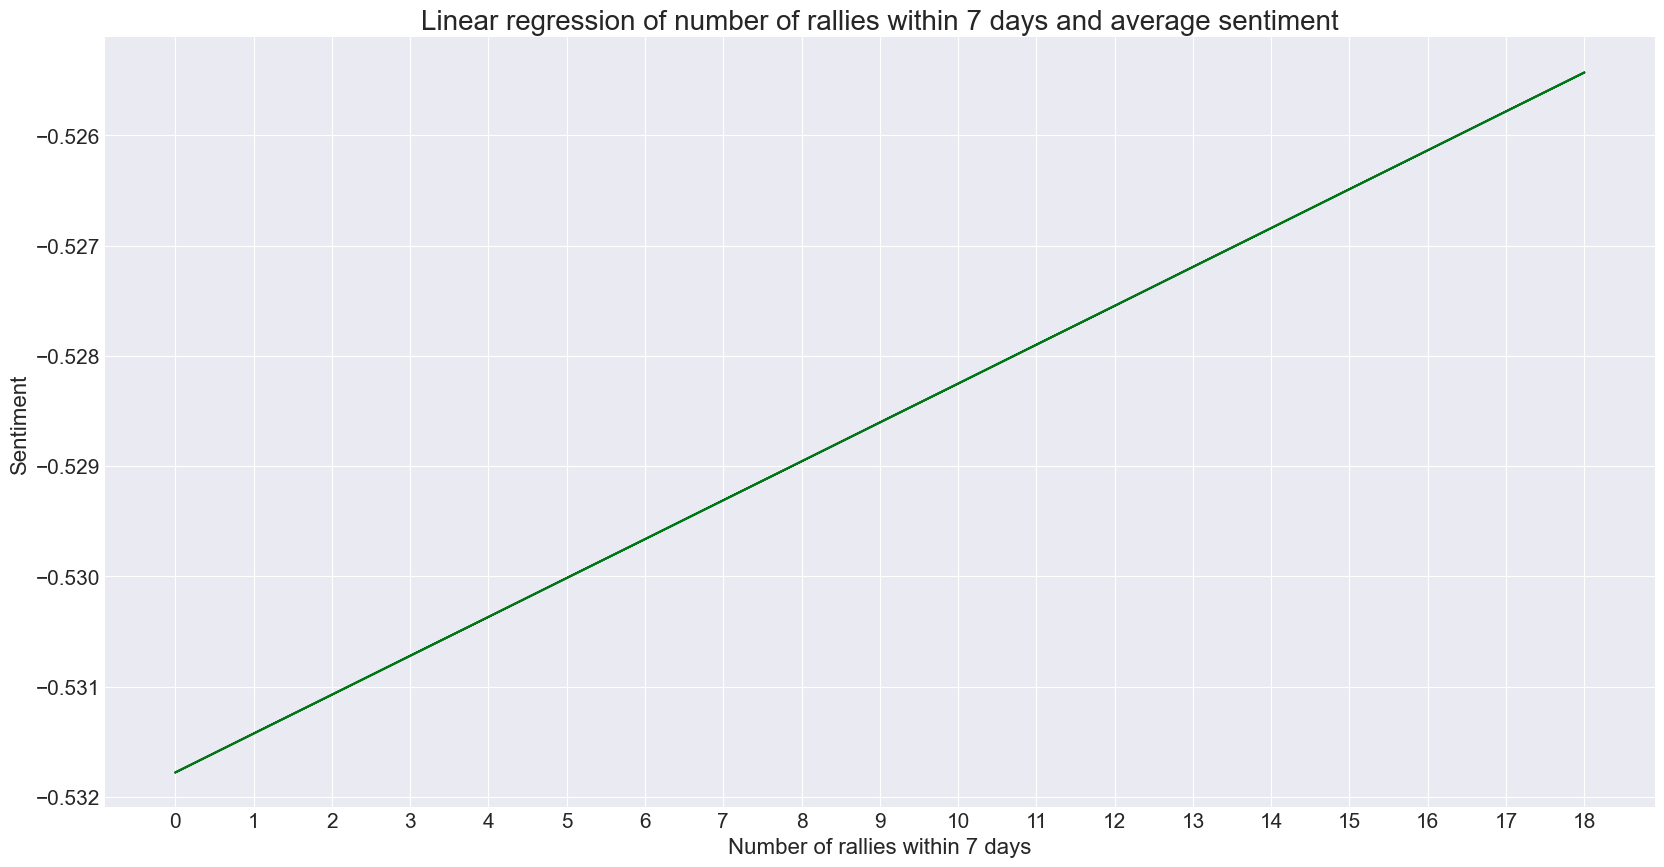

In [253]:
#Simple with stats model (total average)
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xticks(range(0,21,1))
ax.set_title('Linear regression of number of rallies within 7 days and average sentiment') 
ax.title.set_fontsize(20) 
ax.set_xlabel('Number of rallies within 7 days')
ax.xaxis.label.set_fontsize(16)
ax.set_ylabel('Sentiment')
ax.yaxis.label.set_fontsize(16)

x = sm.add_constant(x)
stats_simple = sm.OLS(y1, x)
results = stats_simple.fit()
print(results.summary())
m = results.params[1:]
b = results.params[0]
plt.plot(x, m*x+b)

In [146]:
#cooks distance
influence = results.get_influence()
cooks = influence.cooks_distance

In [147]:
sk = 4 / len(regression_df)
cooks_df = regression_df.copy()
sk

0.01639344262295082

In [148]:
cooks_df['cooks_distance'] = cooks[0]

In [149]:
#Finding the cooks distance that is over our significant value
cooks_df = cooks_df[['date', 'tweet_count', 'total_avg', 'within_7_days', 'cooks_distance']]
cooks_df[cooks_df['cooks_distance'] >= sk].sort_values(by='cooks_distance', ascending=False)

,date,tweet_count,total_avg,within_7_days,cooks_distance
146,2020-10-31,8,-0.533050,20,0.178252
137,2020-10-22,2,-0.608350,9,0.046037
131,2020-10-16,2,-0.666850,8,0.045401
141,2020-10-26,16,0.205369,14,0.043688
144,2020-10-29,7,0.130686,16,0.036839
17,2020-06-08,1,0.846600,0,0.031600
142,2020-10-27,5,0.183360,13,0.030996
15,2020-06-06,1,0.807400,0,0.028912
139,2020-10-24,2,0.276950,10,0.028803
148,2020-11-02,14,0.078443,17,0.027402


In [257]:
pos_neg_df = regression_df.copy()

In [258]:
pos_neg_df = pos_neg_df.dropna(axis='rows')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.285
Date:                Mon, 22 Aug 2022   Prob (F-statistic):              0.132
Time:                        11:25:47   Log-Likelihood:                 139.78
No. Observations:                 190   AIC:                            -275.6
Df Residuals:                     188   BIC:                            -269.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4950      0.009     53.023      0.0

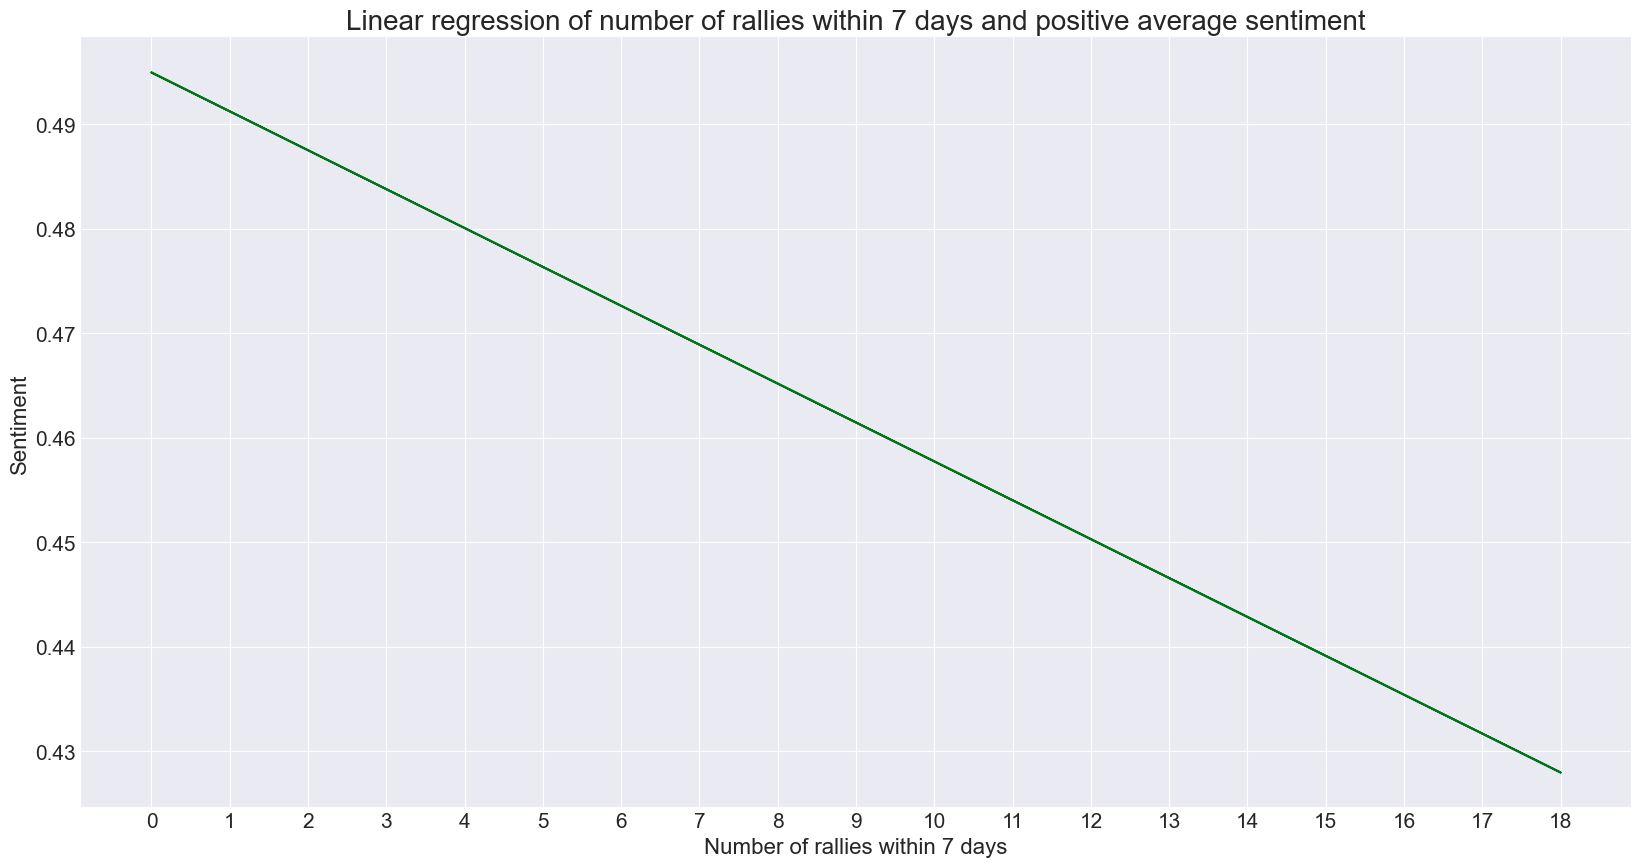

In [260]:
#Positive regression
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Linear regression of number of rallies within 7 days and positive average sentiment') 
ax.title.set_fontsize(20) 
ax.set_xlabel('Number of rallies within 7 days')
ax.xaxis.label.set_fontsize(16)
ax.set_ylabel('Sentiment')
ax.yaxis.label.set_fontsize(16)
ax.set_xticks(range(0,21,1))
#Get our x and y's
x = np.array(pos_neg_df['within_7_days']).reshape((-1, 1))
y1 = np.array(pos_neg_df['positive_avg'])
#Simple with stats model (total average)
x = sm.add_constant(x)
stats_simple = sm.OLS(y1, x)
results = stats_simple.fit()
print(results.summary())
m = results.params[1:]
b = results.params[0]
plt.plot(x, m*x+b)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.02200
Date:                Mon, 22 Aug 2022   Prob (F-statistic):              0.882
Time:                        11:26:04   Log-Likelihood:                 146.45
No. Observations:                 190   AIC:                            -288.9
Df Residuals:                     188   BIC:                            -282.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5318      0.009    -59.003      0.0

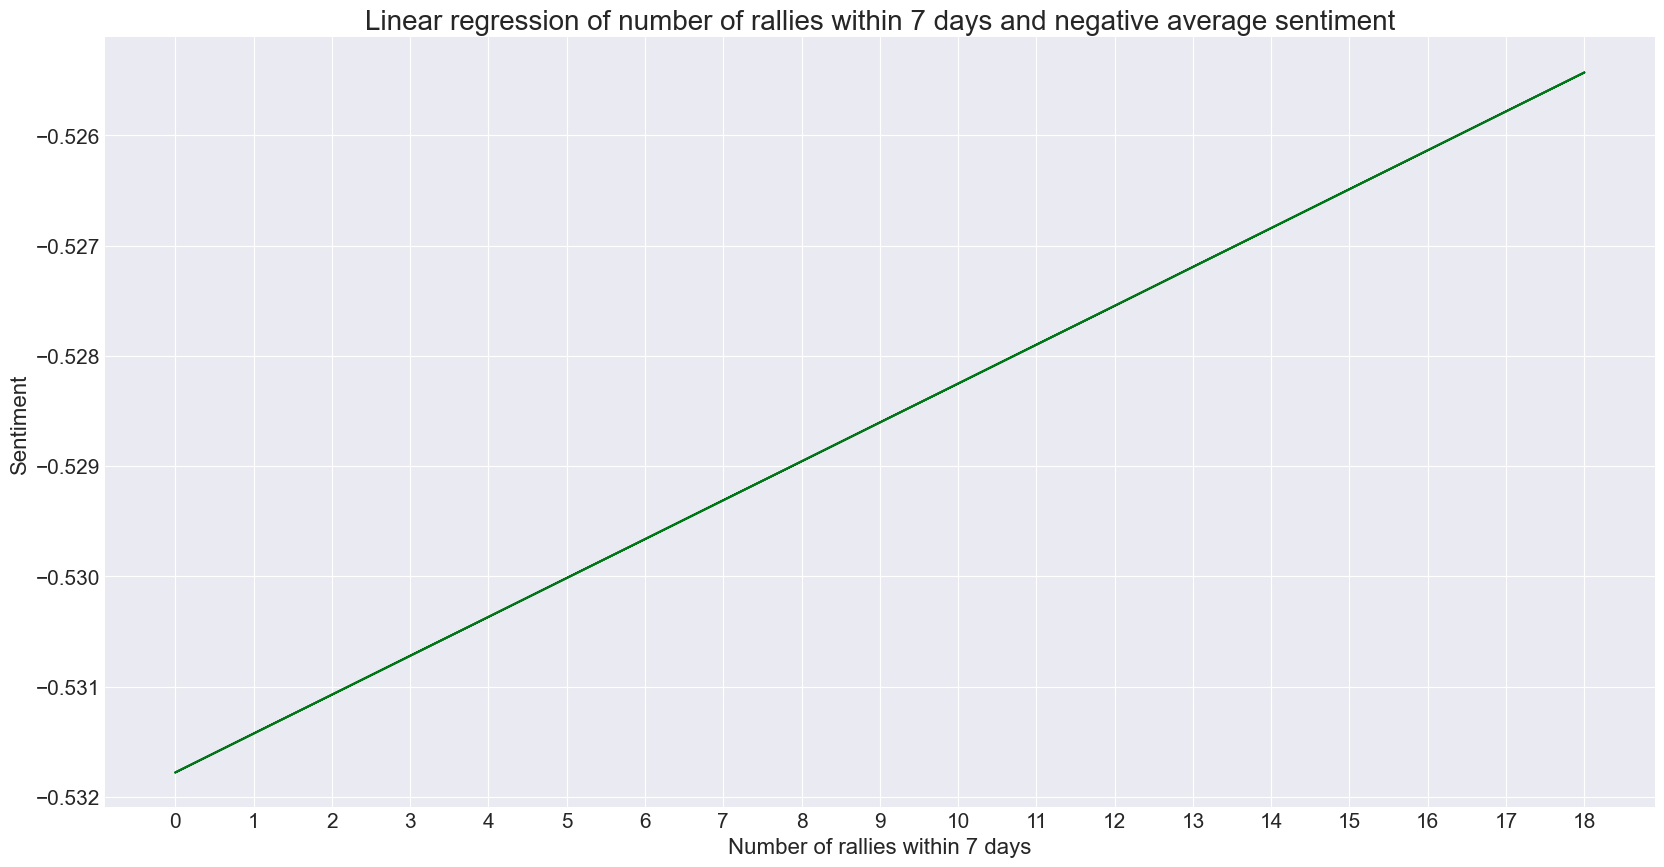

In [262]:
#Negative regression
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Linear regression of number of rallies within 7 days and negative average sentiment') 
ax.title.set_fontsize(20) 
ax.set_xlabel('Number of rallies within 7 days')
ax.xaxis.label.set_fontsize(16)
ax.set_ylabel('Sentiment')
ax.yaxis.label.set_fontsize(16)
ax.set_xticks(range(0,21,1))
#Get our x and y's
x = np.array(pos_neg_df['within_7_days']).reshape((-1, 1))
y1 = np.array(pos_neg_df['negative_avg'])
#Simple with stats model (total average)
x = sm.add_constant(x)
stats_simple = sm.OLS(y1, x)
results = stats_simple.fit()
print(results.summary())
m = results.params[1:]
b = results.params[0]
plt.plot(x, m*x+b)

### Make a nice plot of our regression prediction and the actual correlation

## Bag of words

In [12]:
tweets_for_bag = pd.read_csv('tweets_for_bag.csv')

In [14]:
tweets_for_bag.drop('Unnamed: 0', axis=1, inplace=True)
tweets_for_bag

,cleaned text,sentiment_score,date
0,prediction: every primetime host tonight will...,-0.6486,2021-02-05
1,i don't understand - since we all know the ele...,-0.4939,2021-02-05
2,trump2020,0.0000,2021-02-05
3,thank you for keeping the greatest president ...,0.8655,2021-02-05
4,i just found out that someone stole a bunch o...,0.5719,2021-02-05
...,...,...,...
172450,!democrats stink 💣 backfires! 👇 democrats paid...,-0.5080,2020-05-21
172451,announces charges against philadelphia electi...,-0.3818,2020-05-21
172452,"333+millionpopulation, 100,000+died =...",0.0000,2020-05-21
172453,strange 'cause trump mailed in his last vote...,-0.2023,2020-05-21


In [19]:
tfidf = TfidfVectorizer()
x = tweets_for_bag.copy().dropna(axis="rows")['cleaned text'].values
y = tweets_for_bag.copy().dropna(axis="rows")['sentiment_score'].values
for i in range(len(y)):
    if y[i] >= 0:
        y[i] = 1
    else:
        y[i] = 0        
x_bag = tfidf.fit_transform(x)

In [20]:
lr = LogisticRegression(random_state=0)
lr.fit(x_bag, y)

LogisticRegression(random_state=0)

In [22]:
features = ['_'.join(s.split()) for s in tfidf.get_feature_names_out()]

coefficients = lr.coef_

coefs_df = pd.DataFrame.from_records(coefficients, columns=features)
coefs_df

,00,000,0000,00000,000000,000000189,000007,0000074,00003,00008,...,𝘰𝘶𝘳,𝙍𝙝𝙞𝙣𝙤𝙨,𝙎𝙞𝙙𝙣𝙚𝙮,𝙒𝙚,𝙔𝙤𝙪,𝙜𝙤,𝙡𝙤𝙫𝙚,𝙪𝘾𝙧𝙪𝙨𝙝,𝚏𝚛𝚊𝚞𝚍only,𝚠𝚒𝚍𝚎𝚜𝚙𝚛𝚎𝚊𝚍
0,0.300889,-0.615553,-0.10388,-0.011373,0.010995,0.137097,-0.067501,-0.037971,-0.005607,-0.251853,...,0.017884,0.018184,0.018184,0.018184,0.018184,0.018184,0.018184,0.018184,0.067439,0.067439


In [25]:
#20 best
print(coefs_df.T.sort_values(by=[0], ascending=False).head(20))
#20 worst
print(coefs_df.T.sort_values(by=[0], ascending=True).head(20))

                   0
great      10.361311
love        8.663508
freedom     7.239193
supreme     6.821597
justice     6.643682
best        6.571576
won         6.510902
greatest    6.438194
thank       5.904870
free        5.735404
wow         5.705374
strong      5.602697
wins        5.467832
honest      5.310891
winner      5.285126
pretty      5.216120
integrity   5.204040
thanks      4.990372
save        4.971960
share       4.910241
                    0
fraud      -17.299535
steal      -12.174066
hell       -11.692673
dead       -11.220765
stealing    -9.984382
fraudulent  -9.935805
no          -9.786312
illegal     -9.768496
fake        -9.589859
war         -9.314387
stolen      -9.166430
bad         -8.771666
fight       -8.737655
cheating    -8.630817
evil        -8.421084
violence    -8.366461
bullshit    -7.734021
wrong       -7.663713
lying       -7.646235
failed      -7.589104
